<a href="https://colab.research.google.com/github/danyrpppp/DanielMendez/blob/main/Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nombres de las columnas en el DataFrame:
Index(['Source Airport Code', 'Source Airport Name', 'Source Airport City',
       'Source Airport Country', 'Source Airport Latitude',
       'Source Airport Longitude', 'Destination Airport Code',
       'Destination Airport Name', 'Destination Airport City',
       'Destination Airport Country', 'Destination Airport Latitude',
       'Destination Airport Longitude'],
      dtype='object')


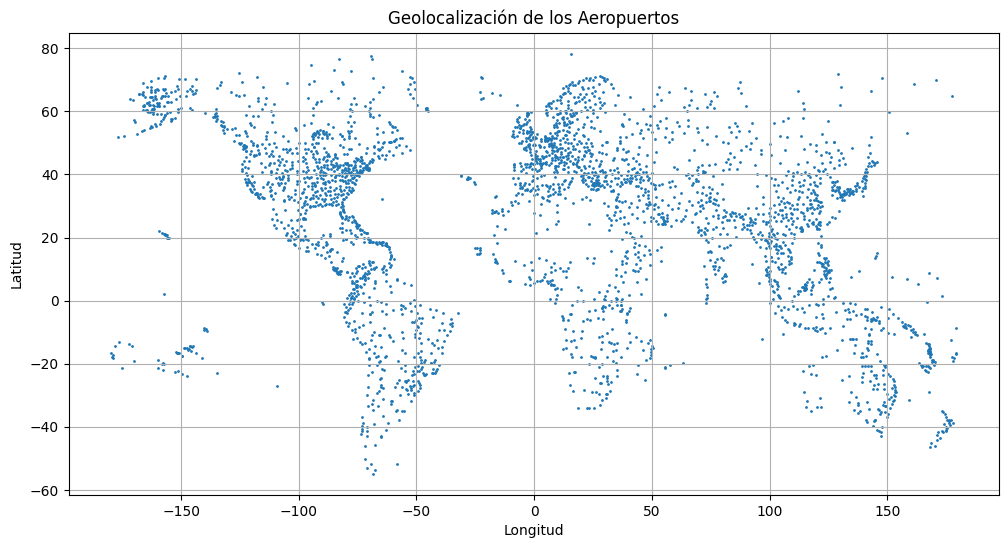

El grafo no es conexo. Tiene 7 componentes.
Componente 1 tiene 3230 vértices.
Componente 2 tiene 4 vértices.
Componente 3 tiene 4 vértices.
Componente 4 tiene 10 vértices.
Componente 5 tiene 4 vértices.
Componente 6 tiene 2 vértices.
Componente 7 tiene 2 vértices.


AttributeError: 'UnionFind' object has no attribute 'union'

In [ ]:
# Importar las librerías necesarias
import pandas as pd
import math
import matplotlib.pyplot as plt

# Leer el archivo CSV
df = pd.read_csv('/content/drive/MyDrive/Collab/flights_final.csv')

# Verificar los nombres de las columnas
print("Nombres de las columnas en el DataFrame:")
print(df.columns)

# Definir la función haversine para calcular distancias entre coordenadas geográficas
def haversine(lat1, lon1, lat2, lon2):
    # Convertir grados decimales a radianes
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Fórmula de haversine corregida
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a))

    r = 6371  # Radio de la Tierra en kilómetros
    return c * r

# Construir el diccionario de aeropuertos y el grafo
aeropuertos = {}  # clave: código del aeropuerto, valor: diccionario con información
grafo = {}        # lista de adyacencia, clave: código del aeropuerto, valor: dict de aeropuertos vecinos y peso

for index, row in df.iterrows():
    # Información del aeropuerto origen
    codigo_origen = row['Source Airport Code']
    if pd.isna(codigo_origen):
        continue  # Omitir filas con datos faltantes
    info_origen = {
        'code': codigo_origen,
        'name': row['Source Airport Name'],
        'city': row['Source Airport City'],
        'country': row['Source Airport Country'],
        'latitude': row['Source Airport Latitude'],
        'longitude': row['Source Airport Longitude']
    }
    # Información del aeropuerto destino
    codigo_destino = row['Destination Airport Code']
    if pd.isna(codigo_destino):
        continue  # Omitir filas con datos faltantes
    info_destino = {
        'code': codigo_destino,
        'name': row['Destination Airport Name'],
        'city': row['Destination Airport City'],
        'country': row['Destination Airport Country'],
        'latitude': row['Destination Airport Latitude'],
        'longitude': row['Destination Airport Longitude']
    }
    # Agregar aeropuertos al diccionario de aeropuertos
    if codigo_origen not in aeropuertos:
        aeropuertos[codigo_origen] = info_origen
    if codigo_destino not in aeropuertos:
        aeropuertos[codigo_destino] = info_destino
    # Calcular la distancia entre el origen y el destino
    lat1 = info_origen['latitude']
    lon1 = info_origen['longitude']
    lat2 = info_destino['latitude']
    lon2 = info_destino['longitude']
    if pd.isna(lat1) or pd.isna(lon1) or pd.isna(lat2) or pd.isna(lon2):
        continue  # Omitir si faltan coordenadas
    distancia = haversine(lat1, lon1, lat2, lon2)
    # Agregar arista al grafo
    if codigo_origen not in grafo:
        grafo[codigo_origen] = {}
    if codigo_destino not in grafo:
        grafo[codigo_destino] = {}
    grafo[codigo_origen][codigo_destino] = distancia
    grafo[codigo_destino][codigo_origen] = distancia  # Como es no dirigido

# Graficar la geolocalización de todos los aeropuertos
todas_latitudes = [info['latitude'] for info in aeropuertos.values()]
todas_longitudes = [info['longitude'] for info in aeropuertos.values()]

plt.figure(figsize=(12, 6))
plt.scatter(todas_longitudes, todas_latitudes, s=1)
plt.title('Geolocalización de los Aeropuertos')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(True)
plt.show()

# Función para realizar DFS y encontrar componentes conectadas
def dfs(grafo, inicio, visitados):
    stack = [inicio]
    componente = []
    while stack:
        vertice = stack.pop()
        if vertice not in visitados:
            visitados.add(vertice)
            componente.append(vertice)
            stack.extend(set(grafo[vertice].keys()) - visitados)
    return componente

def encontrar_componentes_conectadas(grafo):
    visitados = set()
    componentes = []
    for vertice in grafo.keys():
        if vertice not in visitados:
            componente = dfs(grafo, vertice, visitados)
            componentes.append(componente)
    return componentes

# Determinar si el grafo es conexo y encontrar componentes
componentes = encontrar_componentes_conectadas(grafo)
if len(componentes) == 1:
    print("El grafo es conexo.")
else:
    print(f"El grafo no es conexo. Tiene {len(componentes)} componentes.")
    for i, componente in enumerate(componentes):
        print(f"Componente {i+1} tiene {len(componente)} vértices.")

# Estructura Union-Find para el algoritmo de Kruskal
class UnionFind:
    def __init__(self, nodos):
        # Inicializar el padre de cada nodo con él mismo (self-loop)
        self.padre = {nodo: nodo for nodo in nodos}
        self.rango = {nodo: 0 for nodo in nodos}

    def encontrar(self, nodo):
        # Encontrar la raíz del conjunto del nodo (con compresión de camino)
        if self.padre[nodo] != nodo:
          self.padre[nodo] = self.encontrar(self.padre[nodo])
        return self.padre[nodo]

    def unir(self, nodo1, nodo2):
        # Unir dos conjuntos basados en el rango
        raiz1 = self.encontrar(nodo1)
        raiz2 = self.encontrar(nodo2)

        if raiz1 != raiz2:
            # Unir por rango (un nodo de menor rango se conecta al de mayor rango)
            if self.rango[raiz1] > self.rango[raiz2]:
                self.padre[raiz2] = raiz1
            elif self.rango[raiz1] < self.rango[raiz2]:
                self.padre[raiz1] = raiz2
            else:
                self.padre[raiz2] = raiz1
                self.rango[raiz1] += 1

# Algoritmo de Kruskal para encontrar el árbol de expansión mínima
def kruskal_mst(nodos_componente, grafo):
    # Crear una lista de aristas en la componente
    aristas = []
    for u in nodos_componente:
        for v, peso in grafo[u].items():
            if v in nodos_componente and (v, u, peso) not in aristas:
                aristas.append((u, v, peso))
    # Ordenar aristas por peso
    aristas.sort(key=lambda x: x[2])
    uf = UnionFind(nodos_componente)
    peso_mst = 0
    aristas_mst = []
    for u, v, peso in aristas:
        if uf.union(u, v):
            aristas_mst.append((u, v, peso))
            peso_mst += peso
    return peso_mst, aristas_mst

# Determinar el peso del árbol de expansión mínima para cada componente
for i, componente in enumerate(componentes):
    peso_mst, aristas_mst = kruskal_mst(componente, grafo)
    print(f"Peso del árbol de expansión mínima de la componente {i+1}: {peso_mst:.2f} km")

# Función para realizar el algoritmo de Dijkstra
def dijkstra(grafo, inicio):
    distancias = {vertice: float('inf') for vertice in grafo}
    previo = {vertice: None for vertice in grafo}
    distancias[inicio] = 0
    vertices = set(grafo.keys())
    while vertices:
        vertice_actual = min(vertices, key=lambda vertice: distancias[vertice])
        vertices.remove(vertice_actual)
        for vecino, peso in grafo[vertice_actual].items():
            if vecino in vertices:
                alt = distancias[vertice_actual] + peso
                if alt < distancias[vecino]:
                    distancias[vecino] = alt
                    previo[vecino] = vertice_actual
    return distancias, previo

# Interacción con el usuario para las funcionalidades 3 y 4
first_airport_code = input("Ingrese el código del primer aeropuerto: ").strip().upper()
if first_airport_code not in aeropuertos:
    print("Código de aeropuerto no encontrado.")
else:
    # Mostrar la información del aeropuerto
    info = aeropuertos[first_airport_code]
    print(f"Información del aeropuerto:")
    print(f"Código: {info['code']}")
    print(f"Nombre: {info['name']}")
    print(f"Ciudad: {info['city']}")
    print(f"País: {info['country']}")
    print(f"Latitud: {info['latitude']}")
    print(f"Longitud: {info['longitude']}")
    # Encontrar la componente conectada que contiene este aeropuerto
    for componente in componentes:
        if first_airport_code in componente:
            break
    # Ejecutar el algoritmo de Dijkstra
    distancias, previo = dijkstra({k: grafo[k] for k in componente}, first_airport_code)
    # Encontrar los 10 aeropuertos con los caminos mínimos más largos
    distancias_finitas = {k: v for k, v in distancias.items() if v < float('inf')}
    distancias_ordenadas = sorted(distancias_finitas.items(), key=lambda x: x[1], reverse=True)
    print("Los 10 aeropuertos con los caminos mínimos más largos desde el aeropuerto dado:")
    for i, (codigo, dist) in enumerate(distancias_ordenadas[:10]):
        info = aeropuertos[codigo]
        print(f"{i+1}. Código: {info['code']}, Nombre: {info['name']}, Ciudad: {info['city']}, País: {info['country']}, Latitud: {info['latitude']}, Longitud: {info['longitude']}, Distancia: {dist:.2f} km")
    # Funcionalidad 4: Encontrar el camino mínimo hacia un segundo aeropuerto
    second_airport_code = input("Ingrese el código del segundo aeropuerto: ").strip().upper()
    if second_airport_code not in aeropuertos:
        print("Código de aeropuerto no encontrado.")
    else:
        if distancias.get(second_airport_code, float('inf')) == float('inf'):
            print("No existe un camino entre los dos aeropuertos.")
        else:
            # Reconstruir el camino
            camino = []
            actual = second_airport_code
            while actual is not None:
                camino.append(actual)
                actual = previo[actual]
            camino = camino[::-1]  # Invertir el camino
            print("Camino mínimo entre los dos aeropuertos:")
            for codigo in camino:
                info = aeropuertos[codigo]
                print(f"Código: {info['code']}, Nombre: {info['name']}, Ciudad: {info['city']}, País: {info['country']}, Latitud: {info['latitude']}, Longitud: {info['longitude']}")
            # Graficar el camino en el mapa
            latitudes_camino = [aeropuertos[codigo]['latitude'] for codigo in camino]
            longitudes_camino = [aeropuertos[codigo]['longitude'] for codigo in camino]

            plt.figure(figsize=(12, 6))
            plt.plot(todas_longitudes, todas_latitudes, 'b.', markersize=1)
            plt.plot(longitudes_camino, latitudes_camino, 'ro-', markersize=5)
            plt.title('Camino Mínimo entre los Dos Aeropuertos')
            plt.xlabel('Longitud')
            plt.ylabel('Latitud')
            plt.grid(True)
            plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
